In [1]:
import os
import pandas as pd
from os.path import splitext

# 1. `load_original_db`

In [2]:
bc2013_path = '/data2/sungjaecho/data_tts/BC2013'

In [3]:
segment_dir = os.path.join(bc2013_path, 'segments')
transcript_dir = os.path.join(bc2013_path, 'transcripts')
book_dirs = [f for f in os.listdir(segment_dir) \
    if not os.path.isfile(os.path.join(segment_dir, f))]

df_txt_books = list()
for book_dir in book_dirs:
    txt_dir = os.path.join(transcript_dir, book_dir)
    txts = [f for f in os.listdir(txt_dir) if splitext(f)[1] == '.txt']
    df_txt_chapters = list()
    for txt in txts:
        chapter = int(splitext(txt)[0])
        txt_path = os.path.join(txt_dir, txt)
        df_txt = pd.read_csv(txt_path, sep='|', header=None, encoding='utf-8', quoting=3)
        df_txt = df_txt.rename(columns={0:"sentence_id", 1:"text"})
        df_txt['chapter'] = [chapter] * len(df_txt)
        df_txt_chapters.append(df_txt)
    df_txt_chapters = pd.concat(df_txt_chapters)
    df_txt_chapters['book'] = [book_dir] * len(df_txt_chapters)
    df_txt_books.append(df_txt_chapters)
df_txt_books = pd.concat(df_txt_books)
df_txt_books['segmented'] = [False] * len(df_txt_books)
df_txt_books = df_txt_books.reset_index(drop=True)

In [4]:
rm_i_list = list()
rm_wav_paths = list()
log_file = 'log_nonexisting_wavs.txt'
df_txt_books['wav_path'] = [''] * len(df_txt_books)
for i, row in df_txt_books.iterrows():
    wav = '{:02d}-{:06d}.wav'.format(row.chapter, row.sentence_id)
    wav_path = os.path.join(segment_dir, row.book, wav)
    if not os.path.exists(wav_path):
        rm_i_list.append(i)
        rm_wav_paths.append(wav_path)
    else:
        df_txt_books.at[i,'wav_path'] = wav_path

with open(log_file, 'w') as f:
    for rm_wav_path in rm_wav_paths:
        f.write(rm_wav_path)
        f.write('\n')
        
df_txt_books = df_txt_books.drop(rm_i_list)
df_txt_books = df_txt_books.reset_index(drop=True)

print("{} wav files do not exist. Those files are logged in {}.".format(len(rm_wav_paths), log_file))
print("Corresponding scripts are removed.")

6947 wav files do not exist. Those files are logged in log_nonexisting_wavs.txt.
Corresponding scripts are removed.


In [5]:
df_txt_books.head()

,sentence_id,text,chapter,book,segmented,wav_path
0,1,When Ethan was called back to the farm by his ...,8,ethan_frome,False,/data2/sungjaecho/data_tts/BC2013/segments/eth...
1,2,"Here he had nailed up shelves for his books, b...",8,ethan_frome,False,/data2/sungjaecho/data_tts/BC2013/segments/eth...
2,3,"He still took refuge there in summer, but when...",8,ethan_frome,False,/data2/sungjaecho/data_tts/BC2013/segments/eth...
3,4,To this retreat he descended as soon as the ho...,8,ethan_frome,False,/data2/sungjaecho/data_tts/BC2013/segments/eth...
4,5,After Zeena's departure he and Mattie had stoo...,8,ethan_frome,False,/data2/sungjaecho/data_tts/BC2013/segments/eth...


In [6]:
segmented_wav_dir = os.path.join(bc2013_path, 'wav')
segmented_txt_dir = os.path.join(bc2013_path, 'txt')
segmented_wavs = [f for f in os.listdir(segmented_wav_dir) \
    if splitext(f)[1] == '.wav']
segmented_txts = [f for f in os.listdir(segmented_txt_dir) \
    if splitext(f)[1] == '.txt']

wav_paths = list()
texts = list()
for txt in segmented_txts:
    f_name = splitext(txt)[0]
    wav_path = os.path.join(segmented_wav_dir, f_name) + '.wav'
    if not os.path.exists(wav_path):
        continue
    
    txt_path = os.path.join(segmented_txt_dir, txt)
    with open(txt_path, 'r') as f:
        text = f.read()
    
    wav_paths.append(wav_path)
    texts.append(text)
    
df = pd.DataFrame({
    'text':texts,
    'wav_path':wav_paths,
    'segmented':[True]*len(wav_paths)
})

df_txt_books = pd.concat([df_txt_books, df], sort=True)
df_txt_books = df_txt_books.reset_index(drop=True)

In [7]:
df_txt_books.head()

,book,chapter,segmented,sentence_id,text,wav_path
0,ethan_frome,8.0,False,1.0,When Ethan was called back to the farm by his ...,/data2/sungjaecho/data_tts/BC2013/segments/eth...
1,ethan_frome,8.0,False,2.0,"Here he had nailed up shelves for his books, b...",/data2/sungjaecho/data_tts/BC2013/segments/eth...
2,ethan_frome,8.0,False,3.0,"He still took refuge there in summer, but when...",/data2/sungjaecho/data_tts/BC2013/segments/eth...
3,ethan_frome,8.0,False,4.0,To this retreat he descended as soon as the ho...,/data2/sungjaecho/data_tts/BC2013/segments/eth...
4,ethan_frome,8.0,False,5.0,After Zeena's departure he and Mattie had stoo...,/data2/sungjaecho/data_tts/BC2013/segments/eth...


# 2. `add_columns`

In [9]:
df_txt_books.columns

Index(['book', 'chapter', 'segmented', 'sentence_id', 'text', 'wav_path'], dtype='object')

# 3. add duration column

In [11]:
import librosa

In [17]:
for i, row in df_txt_books.iterrows():
    y, sr = librosa.load(row.wav_path)
    duration = librosa.get_duration(y, sr)
    duration = round(duration, 3)
    

8.799


# 4. Check linearity of audio duration and script length

Restart the ipython kernel.

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [2]:
import pandas as pd
from os.path import join
metadata_dir = 'metadata'
bc_csv = 'bc2013.csv'
bc_csv_path = join(metadata_dir, bc_csv)
df_bc = pd.read_csv(bc_csv_path)

In [3]:
df_bc.shape

(88111, 13)

In [4]:
df_bc.columns

Index(['database', 'split', 'wav_path', 'duration', 'text', 'speaker', 'sex',
       'emotion', 'lang', 'segmented', 'book', 'chapter', 'sentence_id'],
      dtype='object')

In [5]:
from g2p_en import G2p
from tqdm import tqdm
import numpy as np

In [6]:
g2p = G2p()

In [7]:
y = df_bc.duration
x = list()
print("Converting graphem sequences to phoneme sequences...")
for i, row in tqdm(df_bc.iterrows(), total=len(df_bc)):
    p_seq = g2p(row.text)
    x.append(len(p_seq))

  0%|          | 0/88111 [00:00<?, ?it/s]

Converting graphem sequences to phoneme sequences...


100%|██████████| 88111/88111 [14:48<00:00, 99.18it/s] 


In [8]:
y = y[:len(x)]
y = y.to_numpy()
x = np.asarray(x)

In [9]:
print(y.shape)
print(x.shape)

(88111,)
(88111,)


In [10]:
min_duration = 1 # seconds
max_duration = 10
hard_duration_mask = (y > min_duration) & (y < max_duration)

print("Deleted files under {} sec: {}".format(min_duration, np.invert(hard_duration_mask).sum()))

Deleted files under 1 sec: 0


In [11]:
print(y.shape)
print(x.shape)

(88111,)
(88111,)


In [12]:
import matplotlib.pyplot as plt

Coefficients: 
 [[0.06511846]]
Intercept: 
 0.0
Mean squared error: 0.21
Coefficient of determination: 0.96


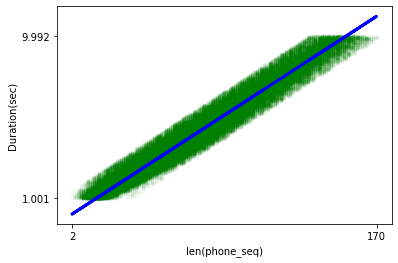

In [13]:
'''
Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
'''
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(x[np.argwhere(hard_duration_mask)], y[np.argwhere(hard_duration_mask)])

# Make predictions using the training set
y_pred = regr.predict(x.reshape(-1, 1))
y_pred = y_pred.reshape(-1)

# The coefficients
print('Coefficients: \n', regr.coef_,)
# The intercpet
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred))

# Plot outputs
plt.scatter(x, y, marker='.', color='green', alpha=0.05)
plt.plot(x, y_pred, color='blue', linewidth=3)

plt.xticks([x.min(), x.max()])
plt.yticks([y.min(), y.max()])
plt.xlabel('len(phone_seq)')
plt.ylabel('Duration(sec)')

plt.show()

In [14]:
# AE: Absolute Error between durations and predicted durations
ae_y = np.abs((y - y_pred))
print(ae_y.shape)

(88111,)


In [15]:
import scipy.stats 

In [16]:
iqr_ae_y = scipy.stats.iqr(ae_y)
q1 = np.quantile(ae_y, 0.25)
q3 = np.quantile(ae_y, 0.75)
lb_ae_y = q1 - 1.5 * iqr_ae_y # Lower bound
ub_ae_y = q3 + 1.5 * iqr_ae_y # Upper bound
print("The lower bound of 1.5*IQR outlying duration absolute errors:", lb_ae_y)
print("The upper bound of 1.5*IQR outlying duration absolute errors:", ub_ae_y)

The lower bound of 1.5*IQR outlying duration absolute errors: -0.43727754638977434
The upper bound of 1.5*IQR outlying duration absolute errors: 1.084854685592323


In [17]:
iqr_y = scipy.stats.iqr(y)
q1_y = np.quantile(y, 0.25)
q3_y = np.quantile(y, 0.75)
lb_y = q1_y - 1.5 * iqr_y # Lower bound
ub_y = q3_y + 1.5 * iqr_y # Upper bound
print("The lower bound of 1.5*IQR outlying durations:", lb_y)
print("The upper bound of 1.5*IQR outlying durations:", ub_y)

The lower bound of 1.5*IQR outlying durations: -2.6570000000000005
The upper bound of 1.5*IQR outlying durations: 10.615


In [18]:
outlier_mask = ((ae_y < lb_ae_y) | (ae_y > ub_ae_y) | (y < lb_y) | (y > ub_y) | np.invert(hard_duration_mask))
i_outliers = np.argwhere(outlier_mask).reshape(-1)
i_inliers = np.argwhere(np.invert(outlier_mask)).reshape(-1)

In [19]:
print(len(i_outliers))
print(len(i_inliers))
n_total = len(i_outliers) + len(i_inliers)
print(n_total)
print(n_total == len(x))

1997
86114
88111
True


In [20]:
def convert(seconds): 
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return hours, minutes, seconds

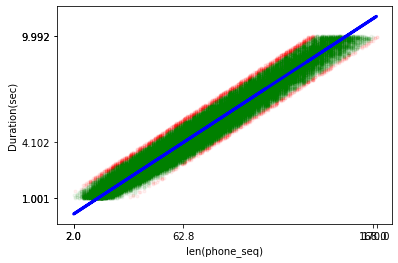

Total samples: 88111
Inliers: 86114
Duration(inliers): 98h 7m 42s
Outliers: 1997
Duration(outliers): 3h 17m 43s
Ratio of Outliers: 0.022664593524077584


In [21]:
x_outliers = x[i_outliers]
y_outliers = y[i_outliers]
x_inliers = x[i_inliers]
y_inliers = y[i_inliers]

# Plot outputs
plt.scatter(x_outliers, y_outliers, color='red', marker='.', alpha=0.05)
plt.scatter(x_inliers, y_inliers, color='green', marker='.', alpha=0.05)


plt.plot(x, y_pred, color='blue', linewidth=3)

plt.xticks([x_inliers.min(), x_inliers.mean(), x_inliers.max(), x.min(), x.max()])
plt.yticks([y_inliers.min(), y_inliers.mean(), y_inliers.max(), y.min(), y.max()])
plt.xlabel('len(phone_seq)')
plt.ylabel('Duration(sec)')

plt.show()

print("Total samples:", len(x))
print("Inliers:", len(x_inliers))
secs_inliers = int(y[i_inliers].sum())
h, m, s = convert(secs_inliers)
print("Duration(inliers): {}h {}m {}s".format(h, m, s))

print("Outliers:", len(x_outliers))
secs_outliers = int(y[i_outliers].sum())
h, m, s = convert(secs_outliers)
print("Duration(outliers): {}h {}m {}s".format(h, m, s))

print("Ratio of Outliers:", (len(x_outliers) / len(x)))

In [22]:
len(x) == len(x_inliers) + len(x_outliers)

True

In [23]:
df_inliers = df_bc.iloc[i_inliers].reset_index(drop=True)
print(df_inliers.shape)
df_inliers.head()

(86114, 13)


,database,split,wav_path,duration,text,speaker,sex,emotion,lang,segmented,book,chapter,sentence_id
0,bc2013,train,/data2/sungjaecho/data_tts/BC2013/segments/eth...,8.799,When Ethan was called back to the farm by his ...,bc2013-w,w,neutral,en,False,ethan_frome,8.0,1.0
1,bc2013,train,/data2/sungjaecho/data_tts/BC2013/segments/eth...,9.609,To this retreat he descended as soon as the ho...,bc2013-w,w,neutral,en,False,ethan_frome,8.0,4.0
2,bc2013,train,/data2/sungjaecho/data_tts/BC2013/segments/eth...,5.951,After Zeena's departure he and Mattie had stoo...,bc2013-w,w,neutral,en,False,ethan_frome,8.0,5.0
3,bc2013,train,/data2/sungjaecho/data_tts/BC2013/segments/eth...,8.956,Then the girl had returned to her task of clea...,bc2013-w,w,neutral,en,False,ethan_frome,8.0,6.0
4,bc2013,train,/data2/sungjaecho/data_tts/BC2013/segments/eth...,2.190,The kitchen was empty when he came back to it;,bc2013-w,w,neutral,en,False,ethan_frome,8.0,7.0


# 5. Functionalizing outlier removal

- **Preprocessing**: Calcuate durations of all audios.

1. Remove samples under 1 second.
1. Find `1.5*IQR` outliers according to duration.
1. Find `1.5*IQR` outliers according to the absolute error for the linear regression model.
1. Remove the two types of outliers.

- **Postprocessing**: `train-val-test` split.

## 5.1. Declarations

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [2]:
import pandas as pd
import numpy as np
import scipy.stats 
from os.path import join
from g2p_en import G2p
from tqdm import tqdm
from sklearn import linear_model

def convert(seconds): 
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return hours, minutes, seconds

In [3]:
def rm_bc_outliers(df_bc, min_duration=1, max_duration=10):
    g2p = G2p()
    y = df_bc.duration
    x = list()
    print("Converting graphem sequences to phoneme sequences...")
    for i, row in tqdm(df_bc.iterrows(), total=len(df_bc)):
        p_seq = g2p(row.text)
        x.append(len(p_seq))

    y = y[:len(x)]
    y = y.to_numpy()
    x = np.asarray(x)

    hard_duration_mask = (y > min_duration) & (y < max_duration)

    print("Deleted files under {} sec: {}".format(min_duration, np.invert(hard_duration_mask).sum()))

    '''
    Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
    '''
    # Create linear regression object
    regr = linear_model.LinearRegression(fit_intercept=False)

    # Train the model using the training sets
    regr.fit(x[np.argwhere(hard_duration_mask)], y[np.argwhere(hard_duration_mask)])

    # Make predictions using the training set
    y_pred = regr.predict(x.reshape(-1, 1))
    y_pred = y_pred.reshape(-1)

    # AE: Absolute Error between durations and predicted durations
    ae_y = np.abs((y - y_pred))

    # Find the lower & upper bounds of 1.5*IQR outlying duration absolute errors
    iqr_ae_y = scipy.stats.iqr(ae_y)
    q1 = np.quantile(ae_y, 0.25)
    q3 = np.quantile(ae_y, 0.75)
    lb_ae_y = q1 - 1.5 * iqr_ae_y # Lower bound
    ub_ae_y = q3 + 1.5 * iqr_ae_y # Upper bound
    print("The lower bound of 1.5*IQR outlying duration absolute errors:", lb_ae_y)
    print("The upper bound of 1.5*IQR outlying duration absolute errors:", ub_ae_y)

    # Find the lower & upper bounds of 1.5*IQR outlying durations
    iqr_y = scipy.stats.iqr(y)
    q1_y = np.quantile(y, 0.25)
    q3_y = np.quantile(y, 0.75)
    lb_y = q1_y - 1.5 * iqr_y # Lower bound
    ub_y = q3_y + 1.5 * iqr_y # Upper bound
    print("The lower bound of 1.5*IQR outlying durations:", lb_y)
    print("The upper bound of 1.5*IQR outlying durations:", ub_y)

    # Get the indicies of outliers
    outlier_mask = ((ae_y < lb_ae_y) | (ae_y > ub_ae_y) | (y < lb_y) | (y > ub_y) | np.invert(hard_duration_mask))
    i_outliers = np.argwhere(outlier_mask).reshape(-1)
    i_inliers = np.argwhere(np.invert(outlier_mask)).reshape(-1)

    x_outliers = x[i_outliers]
    y_outliers = y[i_outliers]
    x_inliers = x[i_inliers]
    y_inliers = y[i_inliers]

    # About stats
    print("Total samples:", len(x))

    # About inliers =====
    print("Inliers:", len(x_inliers))
    secs_inliers = int(y[i_inliers].sum())
    h, m, s = convert(secs_inliers)
    print("Duration(inliers): {}h {}m {}s".format(h, m, s))

    # About outliers =====
    print("Outliers:", len(x_outliers))
    secs_outliers = int(y[i_outliers].sum())
    h, m, s = convert(secs_outliers)
    print("Duration(outliers): {}h {}m {}s".format(h, m, s))
    print("Ratio of Outliers:", (len(x_outliers) / len(x)))
    
    df_inliers = df_bc.iloc[i_inliers].reset_index(drop=True)

    return df_inliers

## 5.2. Running test

In [4]:
metadata_dir = 'metadata'
bc_csv = 'bc2013.csv'
bc_csv_path = join(metadata_dir, bc_csv)
df_bc = pd.read_csv(bc_csv_path)

In [5]:
df_inliers = rm_bc_outliers(df_bc)

  0%|          | 1/106591 [00:00<5:12:06,  5.69it/s]

Converting graphem sequences to phoneme sequences...


100%|██████████| 106591/106591 [07:53<00:00, 224.97it/s]


Deleted files under 1 sec: 15667
The lower bound of 1.5*IQR outlying duration absolute errors: -0.5377316190341649
The upper bound of 1.5*IQR outlying duration absolute errors: 1.2942884639570056
The lower bound of 1.5*IQR outlying durations: -4.480250000000001
The upper bound of 1.5*IQR outlying durations: 13.88175
Total samples: 106591
Inliers: 88111
Duration(inliers): 101h 25m 25s
Outliers: 18480
Duration(outliers): 57h 41m 50s
Ratio of Outliers: 0.17337298646227167


In [6]:
df_inliers.shape

(88111, 13)

## 5.3. Reading results

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [2]:
import pandas as pd

In [3]:
df_bc2013 = pd.read_csv('metadata/bc2013.csv')

In [4]:
df_bc2013.shape

(88111, 13)

In [5]:
df_bc2013[df_bc2013.split == 'train'].shape

(87611, 13)

In [6]:
df_bc2013[df_bc2013.split == 'val'].shape

(100, 13)

In [7]:
df_bc2013[df_bc2013.split == 'test'].shape

(400, 13)

# 6. Draw the histograms of the raw data

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [2]:
import pandas as pd
bc2013_raw_csv_path = 'metadata/bc2013_raw.csv'
df = pd.read_csv(bc2013_raw_csv_path)

In [3]:
print(df.columns)

Index(['database', 'split', 'wav_path', 'duration', 'text', 'speaker', 'sex',
       'emotion', 'lang', 'segmented', 'book', 'chapter', 'sentence_id'],
      dtype='object')


In [4]:
def convert(seconds): 
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return hours, minutes, seconds

## 6.1. About durations

In [5]:
durations = df.duration.to_numpy()

In [6]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np


iqr_y = scipy.stats.iqr(durations)
q1_y = np.quantile(durations, 0.25)
q3_y = np.quantile(durations, 0.75)
lb_y = q1_y - 1.5 * iqr_y # Lower bound
ub_y = q3_y + 1.5 * iqr_y # Upper bound
print("The lower bound of 1.5*IQR outlying durations:", lb_y)
print("The upper bound of 1.5*IQR outlying durations:", ub_y)

plt.title("Histrogram of Duration")
bins = list(range(0,int(durations.max())+1))
n, bins, patches= plt.hist(durations, bins=bins, density=True)
plt.vlines([lb_y, ub_y], n.min(), n.max(), color='r')
plt.vlines([1,10], n.min(), n.max(), color='y')
plt.xlabel('duration(sec)')
plt.show()

The lower bound of 1.5*IQR outlying durations: -4.480250000000001
The upper bound of 1.5*IQR outlying durations: 13.88175


<Figure size 640x480 with 1 Axes>

In [7]:
upper_durations = durations[np.argwhere(durations > ub_y)].reshape(-1)
print(upper_durations.shape)

(5323,)


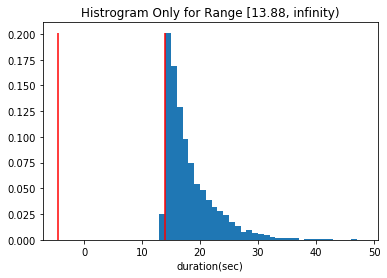

In [8]:
plt.title("Histrogram Only for Range [13.88, infinity)")
bins = list(range(0,int(upper_durations.max())+1))
n, bins, patches= plt.hist(upper_durations, bins=bins, density=True)
plt.vlines([lb_y, ub_y], n.min(), n.max(), color='r')
plt.xlabel('duration(sec)')
plt.show()

## 6.2. About the absolute errors of the linear regression model (x: phoneme_seq_len, y: duration)

In [9]:
from g2p_en import G2p
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 

In [10]:
g2p = G2p()

In [11]:
y = df.duration
x = list()
print("Converting graphem sequences to phoneme sequences...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    p_seq = g2p(row.text)
    x.append(len(p_seq))

  0%|          | 1/106591 [00:00<4:26:10,  6.67it/s]

Converting graphem sequences to phoneme sequences...


100%|██████████| 106591/106591 [21:59<00:00, 80.76it/s] 


In [12]:
y = y[:len(x)]
y = y.to_numpy()
x = np.asarray(x)

In [13]:
print(y.shape)
print(x.shape)

(106591,)
(106591,)


Coefficients: 
 [[0.06538313]]
Intercept: 
 0.0
Mean squared error: 0.33
Coefficient of determination: 0.94


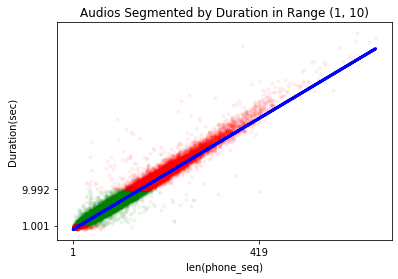

Audios between 1 and 10 secs: 90924
Audios out of duration between 1 and 10 secs: 15667
Total samples: 106591
Inliers: 90924
Duration(inliers): 106h 21m 23s
Outliers: 15667
Duration(outliers): 52h 45m 52s
Ratio of Outliers: 0.14698239063335553


In [23]:
min_duration = 1 # seconds
max_duration = 10
hard_duration_mask = (y > min_duration) & (y < max_duration)
i_hard_duration = np.argwhere(hard_duration_mask)
i_out_duration = np.argwhere(np.invert(hard_duration_mask))

x_in_range = x[i_hard_duration]
y_in_range = y[i_hard_duration]
x_out_range = x[i_out_duration]
y_out_range = y[i_out_duration]

'''
Reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py
'''
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)

# Train the model using the training sets
regr.fit(x_in_range, y_in_range)

# Make predictions using the training set
y_pred = regr.predict(x.reshape(-1, 1))
y_pred = y_pred.reshape(-1)

# The coefficients
print('Coefficients: \n', regr.coef_,)
# The intercpet
print('Intercept: \n', regr.intercept_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_in_range, y_pred[i_hard_duration]))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_in_range, y_pred[i_hard_duration]))

# Plot outputs
plt.title("Audios Segmented by Duration in Range ({}, {})".format(min_duration, max_duration))
plt.scatter(x_in_range, y_in_range, color='green', marker='.', alpha=0.05)
plt.scatter(x_out_range, y_out_range, color='red', marker='.', alpha=0.05)
plt.plot(x, y_pred, color='blue', linewidth=3)

plt.xticks([x_in_range.min(), x_in_range.max()])
plt.yticks([y_in_range.min(), y_in_range.max()])
plt.xlabel('len(phone_seq)')
plt.ylabel('Duration(sec)')

plt.show()

print("Audios between {} and {} secs: {}".format(min_duration, max_duration, hard_duration_mask.sum()))
print("Audios out of duration between {} and {} secs: {}".format(min_duration, max_duration, np.invert(hard_duration_mask).sum()))

print("Total samples:", len(x))
print("Inliers:", len(x_in_range))
secs_inliers = int(y_in_range.sum())
h, m, s = convert(secs_inliers)
print("Duration(inliers): {}h {}m {}s".format(h, m, s))

print("Outliers:", len(x_out_range))
secs_outliers = int(y_out_range.sum())
h, m, s = convert(secs_outliers)
print("Duration(outliers): {}h {}m {}s".format(h, m, s))

print("Ratio of Outliers:", (len(x_out_range) / len(x)))

In [15]:
# AE: Absolute Error between durations and predicted durations
ae_y = np.abs((y - y_pred))
print(ae_y.shape)

(106591,)


In [16]:
iqr_ae_y = scipy.stats.iqr(ae_y)
q1 = np.quantile(ae_y, 0.25)
q3 = np.quantile(ae_y, 0.75)
lb_ae_y = q1 - 1.5 * iqr_ae_y # Lower bound
ub_ae_y = q3 + 1.5 * iqr_ae_y # Upper bound
print("The lower bound of 1.5*IQR outlying duration absolute errors:", lb_ae_y)
print("The upper bound of 1.5*IQR outlying duration absolute errors:", ub_ae_y)

The lower bound of 1.5*IQR outlying duration absolute errors: -0.5377316190341649
The upper bound of 1.5*IQR outlying duration absolute errors: 1.2942884639570056


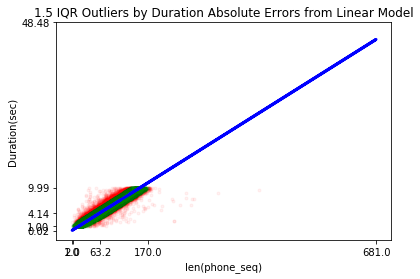

Total samples: 90924
Inliers: 88111
Duration(inliers): 101h 25m 25s
Outliers: 2813
Duration(outliers): 4h 55m 58s
Ratio of Outliers: 0.030937926180106462


In [24]:
outlier_mask = (((ae_y < lb_ae_y) | (ae_y > ub_ae_y)) & hard_duration_mask)
i_outliers = np.argwhere(outlier_mask).reshape(-1)
inlier_mask = ((np.invert((ae_y < lb_ae_y) | (ae_y > ub_ae_y))) & hard_duration_mask)
i_inliers = np.argwhere(inlier_mask).reshape(-1)

x_outliers = x[i_outliers]
y_outliers = y[i_outliers]
x_inliers = x[i_inliers]
y_inliers = y[i_inliers]

plt.title('1.5 IQR Outliers by Duration Absolute Errors from Linear Model')

# Plot outputs
plt.scatter(x_outliers, y_outliers, color='red', marker='.', alpha=0.05)
plt.scatter(x_inliers, y_inliers, color='green', marker='.', alpha=0.05)


plt.plot(x, y_pred, color='blue', linewidth=3)

plt.xticks([x_inliers.min(), x_inliers.mean(), x_inliers.max(), x.min(), x.max()])
plt.yticks([y_inliers.min(), y_inliers.mean(), y_inliers.max(), y.min(), y.max()])
plt.xlabel('len(phone_seq)')
plt.ylabel('Duration(sec)')

plt.show()

print("Total samples:", (len(x_outliers) + len(x_inliers)))
print("Inliers:", len(x_inliers))
secs_inliers = int(y[i_inliers].sum())
h, m, s = convert(secs_inliers)
print("Duration(inliers): {}h {}m {}s".format(h, m, s))

print("Outliers:", len(x_outliers))
secs_outliers = int(y[i_outliers].sum())
h, m, s = convert(secs_outliers)
print("Duration(outliers): {}h {}m {}s".format(h, m, s))

print("Ratio of Outliers:", (len(x_outliers) / (len(x_outliers) + len(x_inliers))))

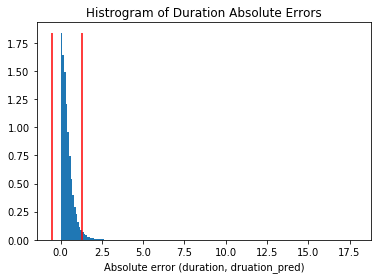

In [18]:
ae_y_clipped = ae_y[np.argwhere(hard_duration_mask)]


bins = np.arange(int(ae_y_clipped.min()),int(ae_y_clipped.max())+1, 0.1)
n, bins, patches= plt.hist(ae_y_clipped, bins=bins, density=True)
plt.vlines([lb_ae_y, ub_ae_y], n.min(), n.max(), color='r')
plt.title('Histrogram of Duration Absolute Errors')
plt.xlabel('Absolute error (duration, druation_pred)')
plt.show()

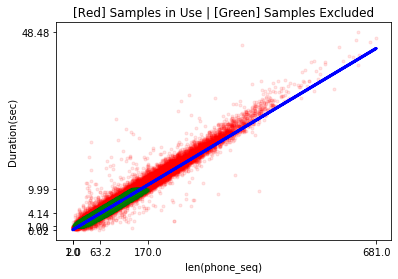

Total samples: 106591
Inliers: 88111
Duration(inliers): 101h 25m 25s
Outliers: 18480
Duration(outliers): 57h 41m 50s
Ratio of Outliers: 0.17337298646227167


In [25]:
outlier_mask = ((ae_y < lb_ae_y) | (ae_y > ub_ae_y) | np.invert(hard_duration_mask))
i_outliers = np.argwhere(outlier_mask).reshape(-1)
i_inliers = np.argwhere(np.invert(outlier_mask)).reshape(-1)

x_outliers = x[i_outliers]
y_outliers = y[i_outliers]
x_inliers = x[i_inliers]
y_inliers = y[i_inliers]

plt.title('[Red] Samples in Use | [Green] Samples Excluded')

# Plot outputs
plt.scatter(x_outliers, y_outliers, color='red', marker='.', alpha=0.1)
plt.scatter(x_inliers, y_inliers, color='green', marker='.',alpha=0.1)


plt.plot(x, y_pred, color='blue', linewidth=3)

plt.xticks([x_inliers.min(), x_inliers.mean(), x_inliers.max(), x.min(), x.max()])
plt.yticks([y_inliers.min(), y_inliers.mean(), y_inliers.max(), y.min(), y.max()])
plt.xlabel('len(phone_seq)')
plt.ylabel('Duration(sec)')

plt.show()

print("Total samples:", len(x))
print("Inliers:", len(x_inliers))
secs_inliers = int(y[i_inliers].sum())
h, m, s = convert(secs_inliers)
print("Duration(inliers): {}h {}m {}s".format(h, m, s))

print("Outliers:", len(x_outliers))
secs_outliers = int(y[i_outliers].sum())
h, m, s = convert(secs_outliers)
print("Duration(outliers): {}h {}m {}s".format(h, m, s))

print("Ratio of Outliers:", (len(x_outliers) / len(x)))

# 7. See the pre-segmented data stats

In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


In [2]:
import pandas as pd
from os.path import join
metadata_dir = 'metadata'
bc_csv = 'bc2013.csv'
bc_csv_path = join(metadata_dir, bc_csv)
df_bc = pd.read_csv(bc_csv_path)

In [3]:
df_bc.shape

(88111, 13)

In [4]:
df_bc.columns

Index(['database', 'split', 'wav_path', 'duration', 'text', 'speaker', 'sex',
       'emotion', 'lang', 'segmented', 'book', 'chapter', 'sentence_id'],
      dtype='object')

In [5]:
df = df_bc[df_bc.segmented == True]

In [6]:
df.shape

(7155, 13)

In [9]:
secs = df.duration.sum()

In [10]:
def convert(seconds): 
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return hours, minutes, seconds

In [13]:
h, m, s = convert(secs)

In [18]:
print("{:d} hours {:d} minutes {:d} seconds".format(int(h), int(m), int(s)))

9 hours 13 minutes 24 seconds
